In [366]:

import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from sklearn.cluster import DBSCAN

In [367]:
def find_directions(lines, tolerance=np.pi / 8):
    horizontal = []
    vertical = []
    for line in lines:
        rho, theta = line[0]
        if abs(theta) < tolerance or abs(theta - np.pi) < tolerance:
            vertical.append((rho, theta))
        elif abs(theta - np.pi / 2) < tolerance:
            horizontal.append((rho, theta))
    return horizontal, vertical


def print_line(img, all_lines, no_copy = False, print_theta = False):
    # if no_copy:
    #     copy = img
    # else:
    #     copy = np.copy(img)
    
    copy = np.copy(img)
    h, w = img.shape
    extension = max(w, h)*1.1
    if all_lines is not None:
        for line in all_lines:
            rho, theta = line
            if print_theta:
                deg = theta*180/np.pi
                print(deg)
                print(rho)
            a = math.cos(theta)
            b = math.sin(theta)
            # Punkt najblizszy srodka ukł. wsp.
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + extension*(-b)), int(y0 + extension*(a)))
            pt2 = (int(x0 - extension*(-b)), int(y0 - extension*(a)))
            cv2.line(copy, pt1, pt2, (255,255,255), 3, cv2.LINE_AA) 
        plt.figure(figsize=(5,5))      
        plt.imshow(copy, cmap='gray')
        return copy

In [368]:
checkboard = cv2.imread("photo/background_checkboard/checkboard3.jpg", cv2.IMREAD_GRAYSCALE )
# equalized = cv2.equalizeHist(checkboard)

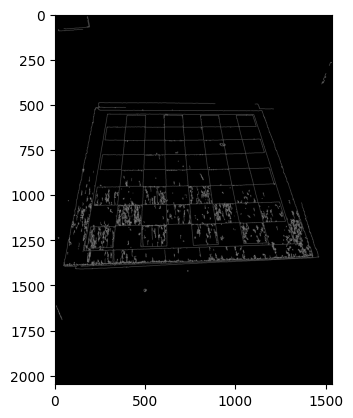

In [369]:
edges = cv2.Canny(checkboard, 50, 200)
plt.imshow(edges, cmap='gray')

In [370]:
lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
print(lines.shape)
# print_line(checkboard, lines)


(53, 1, 2)


In [371]:
horiz, vert = find_directions(lines)
# print_line(checkboard, horiz)

In [372]:
print(len(horiz))
print(len(vert))

42
11


In [373]:
# print_line(checkboard,vert, True, print_theta=True)

In [374]:
def normalize_vertical(rho, theta, idx): 
    rho = (-1)*rho
    theta = np.pi - theta
    idx = -1
    return rho, theta, idx

def mean_line(lines):
    """Calculate the mean line (rho, theta) from a list of lines."""
    rhos = []
    thetas = []
    norm_lines = []
    for i in range(len(lines)):
        rho, theta = lines[i]
        if np.pi - np.pi / 8 <= theta <= np.pi:
            rho, theta, i = normalize_vertical(rho, theta, i)
        rhos.append(rho)
        thetas.append(theta)
        norm_lines.append(i)
    return [np.mean(rhos), np.mean(thetas)], norm_lines



In [375]:
m_vert, norm_vert = mean_line(vert)
m_horiz, norm_horiz = mean_line(horiz)
  
# print(m_vert)
# print(m_horiz)
# print_line(checkboard,[m_vert])

In [376]:
def intersection_point(line1, line2):
    """Oblicza punkt przecięcia dwóch linii w formie (rho, theta)."""
    rho1, theta1 = line1
    rho2, theta2 = line2
    
    # Wyliczamy współczynniki (a1, b1) i (a2, b2) z równań linii w przestrzeni biegunowej
    a1, b1 = np.cos(theta1), np.sin(theta1)
    a2, b2 = np.cos(theta2), np.sin(theta2)
    
    # Obliczamy wyznacznik
    d = a1 * b2 - a2 * b1
    if np.isclose(d, 0):
        return None  
    
    # Obliczamy współrzędne punktu przecięcia
    x = (rho1 * b2 - rho2 * b1) / d
    y = (rho2 * a1 - rho1 * a2) / d
    return (x, y)



In [377]:
x, y = intersection_point(m_horiz, m_vert)
print(x, y)
# image = cv2.circle(checkboard, (int(x),int(y)), radius=10, color=(0, 0, 255),thickness= -1)
# plt.figure(figsize=(10,10))
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

507.93835 1108.595


In [378]:
def cluster_lines(lines1, lines2, eps=20, min_samples=1):
    # Średnia linia pionowa
    mean_vert, norm_lines = mean_line(lines2)

    # Znajdź punkty przecięcia linii poziomych ze średnią pionową linią
    intersections = []
    for h_line in lines1:
        point = intersection_point(h_line, mean_vert)
    
        if point:
            intersections.append(point)
    
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(intersections)
    labels = db.labels_
    # print(len(labels))
    # print(labels[1])


    clustered_lines = []
    for label in set(labels):
        if label == -1:  
            continue

        cluster = []
        for i in range(len(lines1)):
            if labels[i] == label:
                cluster.append(lines1[i])
        mean_cluster, norm_cluster = mean_line(cluster)
        if norm_cluster[0] == -1:
            mean_cluster[0], mean_cluster[1], _ = normalize_vertical(mean_cluster[0], mean_cluster[1], 0)
        clustered_lines.append(mean_cluster)

    return clustered_lines

10


array([[213, 213, 214, ...,  30,  29,  26],
       [218, 218, 217, ...,  30,  29,  27],
       [222, 221, 219, ...,  30,  29,  27],
       ...,
       [ 23,  23,  23, ..., 175, 175, 175],
       [ 23,  23,  23, ..., 175, 175, 175],
       [ 23,  23,  23, ..., 175, 175, 175]], dtype=uint8)

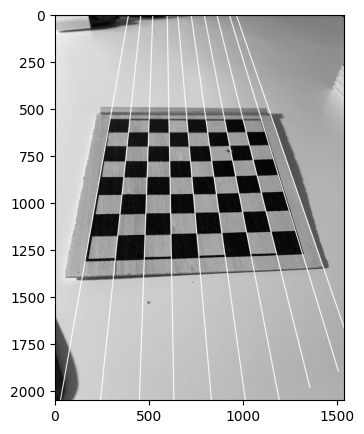

In [379]:
clust_vert = cluster_lines(vert, horiz)
print(len(clust_vert))
print_line(checkboard, clust_vert, print_theta=False)

12


array([[213, 213, 214, ...,  30,  29,  26],
       [218, 218, 217, ...,  30,  29,  27],
       [222, 221, 219, ...,  30,  29,  27],
       ...,
       [ 23,  23,  23, ..., 175, 175, 175],
       [ 23,  23,  23, ..., 175, 175, 175],
       [ 23,  23,  23, ..., 175, 175, 175]], dtype=uint8)

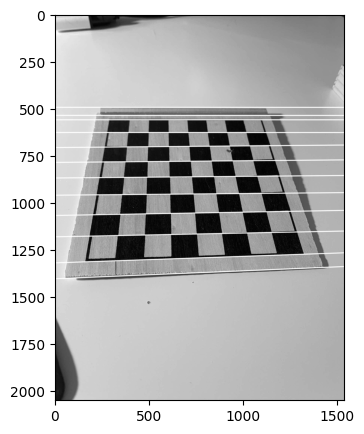

In [380]:
clust_horiz = cluster_lines(horiz, vert)
print(len(clust_horiz))
print_line(checkboard, clust_horiz, print_theta=False)


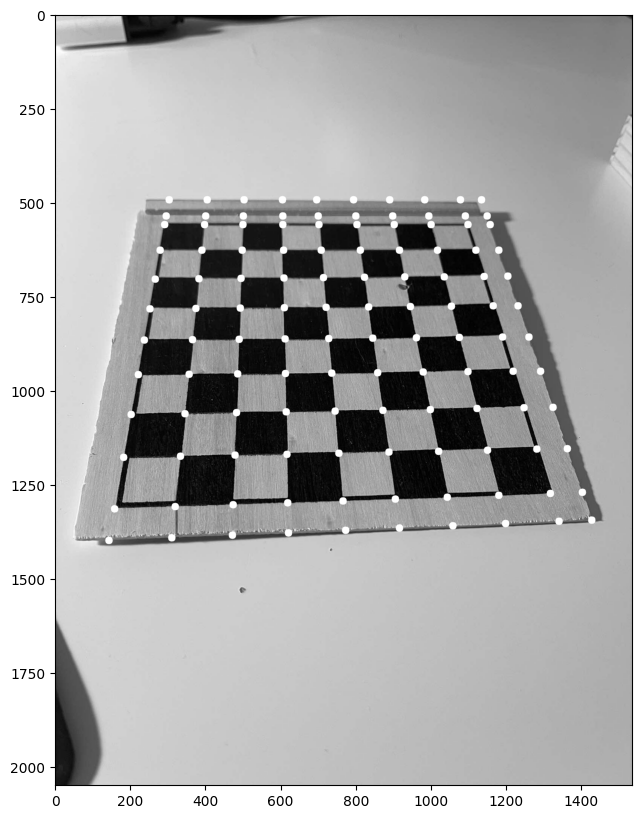

In [381]:
intersections = []
for h in clust_horiz:
    for v in clust_vert:
        x, y = intersection_point(h, v)
        intersections.append((x, y))
        image = cv2.circle(checkboard, (int(x),int(y)), radius=10, color=(255, 0, 0),thickness= -1)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))